In [1]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy
print(scipy.__version__)

1.12.0


In [3]:
pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from scikitplot.metrics import plot_roc
from sklearn.preprocessing import OneHotEncoder


import warnings
warnings.filterwarnings("ignore")


2024-05-19 09:47:41.614772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 09:47:41.614872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 09:47:41.764911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
train = pd.read_csv('/kaggle/input/completed-dataset/train_data.csv')
val = pd.read_csv('/kaggle/input/completed-dataset/val_data.csv')
test = pd.read_csv('/kaggle/input/completed-dataset/test_data.csv')

In [6]:
train = train.drop('path_dicom', axis=1)
val = val.drop('path_dicom', axis=1)
test = test.drop('path_dicom', axis=1)

In [7]:
def normalize_col(df, col):
    normalized_columns = normalize(df[col])

    for i, col in enumerate(col):
        df[col] = normalized_columns[:, i]
    
    return df

In [8]:
cols = ['age_approx', 'sex', 'anatom_site_general_challenge']
train = normalize_col(train, cols)
val = normalize_col(val, cols)
test = normalize_col(test, cols)

In [9]:
# X_train = train.drop('diagnosis', axis=1)  
# y_train = train['diagnosis']  

# X_val = val.drop('diagnosis', axis=1) 
# y_val = val['diagnosis']  

# X_test = test.drop('diagnosis', axis=1)
# y_test = test['diagnosis'] 

In [10]:
# train['diagnosis'] = train['diagnosis'].to_numpy()
# val['diagnosis'] = val['diagnosis'].to_numpy()
# test['diagnosis'] = test['diagnosis'].to_numpy()

In [11]:
def load_image(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.
    
    # Return image
    return image

In [12]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [13]:
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

In [14]:
def encode_labels(labels, encode_depth=4):
    return tf.one_hot(labels, depth=encode_depth)

In [15]:
def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    image_paths = df.path_jpeg
    image_labels = encode_labels(df.diagnosis)
    AUTOTUNE = tf.data.AUTOTUNE
    
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y))
    else:
        ds = ds.map(lambda x, y: (load_function(x), y))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    ds = ds.batch(batch_size)
    
    if cache is not None:
        ds = ds.cache(cache)
    
    if prefetch:
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # Return the dataset
    return ds

In [16]:
train_ds = create_pipeline(train, load_image, augment=True, 
                           batch_size=CFG.BATCH_SIZE, 
                           shuffle=False, prefetch=True)

val_ds = create_pipeline(val, load_image, 
                         batch_size=CFG.BATCH_SIZE, 
                         shuffle=False, prefetch=False)

test_ds = create_pipeline(test, load_image, 
                          batch_size=CFG.BATCH_SIZE, 
                          shuffle=False, prefetch=False)

In [17]:
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


# BASLINE MODEL CNN/

In [18]:
def cnn_model():
    initializer = tf.keras.initializers.GlorotNormal()
    
    cnn_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        
        layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2, padding='valid'),
        
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(4, activation='softmax', kernel_initializer=initializer)  # Change output units to 4 and activation to 'softmax'
    ], name='cnn_sequential_model')
    
    return cnn_sequential

In [19]:
model_cnn = cnn_model()

In [20]:
model_cnn.summary()

Model: "cnn_sequential_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 8)    │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 22472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,876,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881,572 (10.99 MB)

 Trainable params: 2,881,572 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

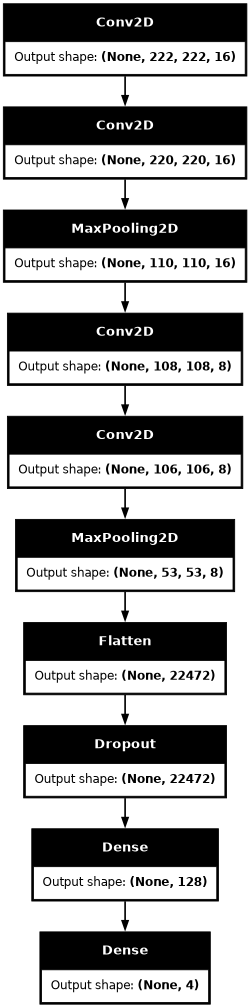

In [21]:
plot_model(
    model_cnn, dpi=60,
    show_shapes=True
)

In [22]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data. 
        
        @params
        - model: (tf.keras.model) -> model to be trained 
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on 
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        
        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''
    
    model_history = {}
    
    if not tf_valid_data:
        validation_data = None
        validation_steps = None
    else:
        validation_data = tf_valid_data
        validation_steps = int(len(tf_valid_data))
        
    model_history = model.fit(tf_train_data,
                              epochs=num_epochs,
                              validation_data=validation_data,
                              validation_steps=validation_steps,
                              callbacks=callbacks_list,
                              shuffle=shuffling)
        
    return model_history

In [23]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    factor=0.1,
    verbose=1)

CUSTOM_CALLBACKS = [early_stopping_callback, reduce_lr_callback]

CUSTOM_METRICS = ['accuracy']

In [24]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_cnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=CUSTOM_METRICS
)

# Train the model
print(f'Training {model_cnn.name}.')
print(f'Train on {len(train)} samples, validate on {len(val)} samples.')
print('----------------------------------')

cnn_history = train_model(
    model_cnn, CFG.EPOCHS, CUSTOM_CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training cnn_sequential_model.
Train on 26160 samples, validate on 4905 samples.
----------------------------------
Epoch 1/10


2024-05-19 09:48:01.562980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49295: 4.25514, expected 3.61721
2024-05-19 09:48:01.563036: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49296: 5.13285, expected 4.49491
2024-05-19 09:48:01.563054: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49346: 5.29403, expected 4.65609
2024-05-19 09:48:01.563072: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49349: 5.09757, expected 4.45964
2024-05-19 09:48:01.563085: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49350: 5.27288, expected 4.63495
2024-05-19 09:48:01.563096: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49351: 5.07595, expected 4.43801
2024-05-19 09:48:01.563106: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49366: 5.21611, expected 4.57817
2024-05-19 09:48:01.563118:

  1/818 ━━━━━━━━━━━━━━━━━━━━ 2:59:43 13s/step - accuracy: 0.0000e+00 - loss: 0.7053

I0000 00:00:1716112088.091968      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


817/818 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9092 - loss: 0.1563

2024-05-19 10:27:45.193116: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49293: 7.29743, expected 6.46071
2024-05-19 10:27:45.193184: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49294: 7.12612, expected 6.2894
2024-05-19 10:27:45.193193: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49295: 5.65411, expected 4.81739
2024-05-19 10:27:45.193201: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49346: 6.79266, expected 5.95594
2024-05-19 10:27:45.193209: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49349: 7.1312, expected 6.29448
2024-05-19 10:27:45.193234: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49350: 6.42717, expected 5.59045
2024-05-19 10:27:45.193242: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49351: 6.82348, expected 5.98675
2024-05-19 10:27:45.193250: E

818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9092 - loss: 0.1563

2024-05-19 10:30:13.868475: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49285: 6.26153, expected 5.44882
2024-05-19 10:30:13.868536: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 6.15561, expected 5.34289
2024-05-19 10:30:13.868550: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 7.09436, expected 6.28164
2024-05-19 10:30:13.868562: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 5.33438, expected 4.52166
2024-05-19 10:30:13.868580: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 5.57214, expected 4.75942
2024-05-19 10:30:13.868591: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 5.38216, expected 4.56944
2024-05-19 10:30:13.868601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 5.14846, expected 4.33574
2024-05-19 10:30:13.868611:

818/818 ━━━━━━━━━━━━━━━━━━━━ 2540s 3s/step - accuracy: 0.9092 - loss: 0.1563 - val_accuracy: 0.9272 - val_loss: 0.1231 - learning_rate: 0.0010
Epoch 2/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 2123s 3s/step - accuracy: 0.9381 - loss: 0.1184 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 2269s 3s/step - accuracy: 0.9331 - loss: 0.1256 - val_accuracy: 0.9372 - val_loss: 0.1164 - learning_rate: 0.0010
Epoch 4/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 2151s 3s/step - accuracy: 0.9295 - loss: 0.1269 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 2260s 3s/step - accuracy: 0.9329 - loss: 0.1219 - val_accuracy: 0.9374 - val_loss: 0.1130 - learning_rate: 0.0010
Epoch 6/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 2084s 3s/step - accuracy: 0.9380 - loss: 0.1202 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 2196s 3s/step - accurac

In [25]:
cnn_evaluation = model_cnn.evaluate(test_ds)

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.9488 - loss: 0.0968

2024-05-19 15:56:06.296217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 197143: 5.77982, expected 5.06264
2024-05-19 15:56:06.296295: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 197145: 6.14431, expected 5.42713
2024-05-19 15:56:06.296304: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 197146: 5.26603, expected 4.54884
2024-05-19 15:56:06.296312: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 197147: 5.0733, expected 4.35611
2024-05-19 15:56:06.296320: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 197164: 5.88631, expected 5.16912
2024-05-19 15:56:06.296328: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 197166: 5.91681, expected 5.19962
2024-05-19 15:56:06.296335: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 197167: 6.10794, expected 5.39076
2024-05-19 15:56:06.2

52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 951ms/step - accuracy: 0.9485 - loss: 0.0973


In [26]:
# Generate model probabilities and associated predictions
cnn_test_probabilities = model_cnn.predict(test_ds, verbose=1)
cnn_test_probabilities

52/52 ━━━━━━━━━━━━━━━━━━━━ 45s 852ms/step


array([[2.5444498e-07, 1.4433890e-04, 9.9952042e-01, 3.3506774e-04],
       [1.3982797e-05, 2.2965938e-05, 8.6822700e-05, 9.9987614e-01],
       [1.9648240e-04, 2.8738609e-04, 8.0071099e-04, 9.9871540e-01],
       ...,
       [7.2869094e-05, 1.1132403e-04, 3.4782541e-04, 9.9946803e-01],
       [3.6758534e-05, 5.7868132e-05, 1.9567129e-04, 9.9970967e-01],
       [1.1359185e-03, 1.5380937e-03, 3.4977398e-03, 9.9382824e-01]],
      dtype=float32)

In [27]:
cnn_test_predictions = tf.argmax(cnn_test_probabilities, axis=1)
cnn_test_predictions

<tf.Tensor: shape=(1636,), dtype=int64, numpy=array([2, 3, 3, ..., 3, 3, 3])>

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

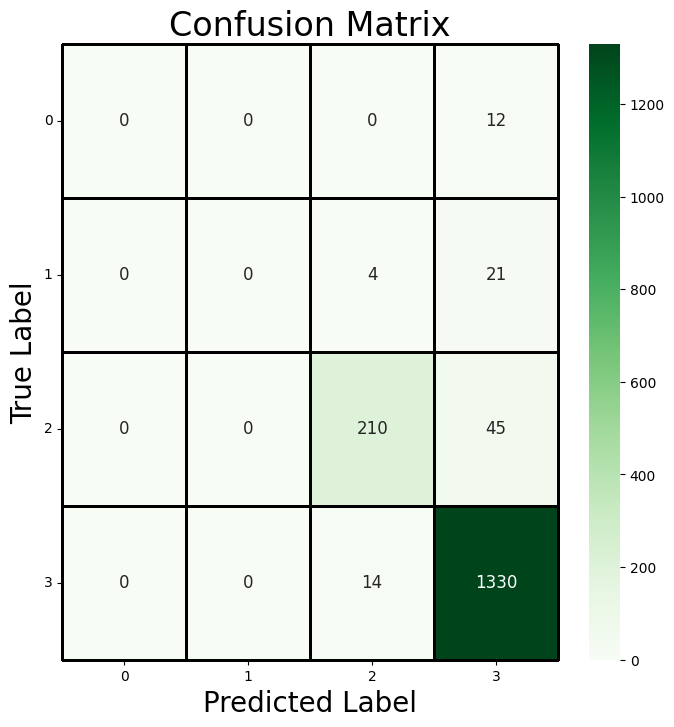

In [29]:
class_names = ['0', '1', '2', '3']

plot_confusion_matrix(
    test.diagnosis,
    cnn_test_predictions, 
    figsize=(8, 8), 
    classes=class_names)

In [30]:
# plot_roc(test.diagnosis , 
#          cnn_test_probabilities, 
#          figsize=(10, 10), title_fontsize='large');

In [31]:
print(classification_report(test.diagnosis , 
                            cnn_test_predictions, 
                            target_names=class_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        25
           2       0.92      0.82      0.87       255
           3       0.94      0.99      0.97      1344

    accuracy                           0.94      1636
   macro avg       0.47      0.45      0.46      1636
weighted avg       0.92      0.94      0.93      1636



In [32]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

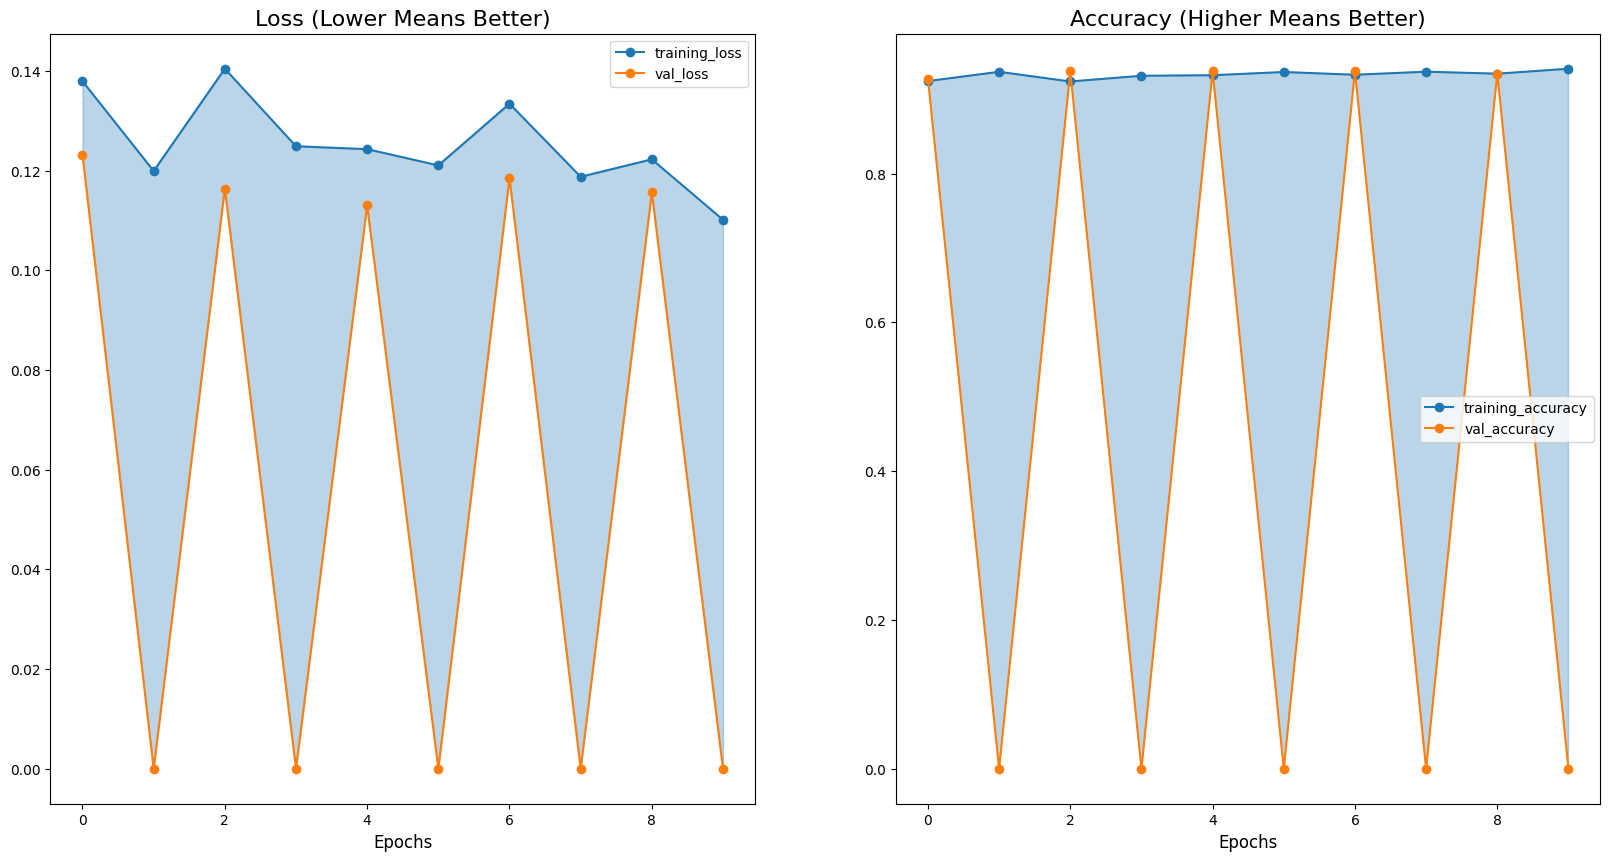

In [33]:
plot_training_curves(cnn_history)

In [34]:
0

0